# STARX - EMG Support Machine Vector Machine Learning:
The python script will calculate the most optimal Support Vector Machine (SVM) from EMG comma seperated value file. 


In [1]:
!pip install micromlgen

import pandas as pd
import numpy as np
import csv
import sklearn
import matplotlib
import matplotlib.pyplot as plt
from glob import glob
from os.path import basename
from sklearn import model_selection
from sklearn import svm
from IPython.display import clear_output
# Stop warning from Y being in list form instead of dp.
import warnings
from sklearn.exceptions import DataConversionWarning
# Library to convert sklearn model to c library file.
from micromlgen import port
# Decision boundary graph library.
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions
# Global Variables:
debug = True

if debug == True:
  print(f"Numpy version = {np.__version__}\n")
  print(f"Pandas version = {pd.__version__}\n")
  print(f"Sklearn version = {sklearn.__version__}\n")
  print(f"MathPlotLib version = {matplotlib.__version__}")

  Created wheel for micromlgen: filename=micromlgen-1.1.18-cp36-none-any.whl size=25961 sha256=a3ca5b84eededa93c25fbc04b6dc3d1d700be09b7df4d6cdc1be10496970524d
  Stored in directory: /root/.cache/pip/wheels/ab/60/35/c881080fab9d9bbac2b7d0f4b7dc8a69de5dbd868c1476ab1e
Successfully built micromlgen
Numpy version = 1.19.4

Pandas version = 1.1.5

Sklearn version = 0.22.2.post1

MathPlotLib version = 3.2.2


## Upload Data

1. Open the panel on the left side of Colab by clicking on the __file__ button
1. Drag `data.csv` files from your computer to the tab to upload them to Google Colab.

Three parts of the leg muscle voltages we will be analysing will include Gastrocnemius (GM), Tibialis Anterior (TA) and Rectus Femoris (RF).

The format of the file should be set up as:


```
Voltage_1,Voltage2,Voltage3,Label
0.232142,0.122421,0.212321,Right_Leg_Up or 0
0.232142,0.122421,0.212321,Right_Leg_Up or 0
0.838743,0.987373,0.735662,Right_Leg_Up or 0
0.778921,0.827471,0.924827,Right_Leg_Down or 1
0.837372,0.092882,0.028221,Right_Leg_Down or 1
0.827472,0.827212,0.872476,Right_Leg_Down or 1
```

## Graph Data

We'll graph the input file on a graph with Sample Number on X axis and Voltage on Y axis.

Label values: 
[[ 33]
 [ 33]
 [ 31]
 ...
 [626]
 [601]
 [574]]


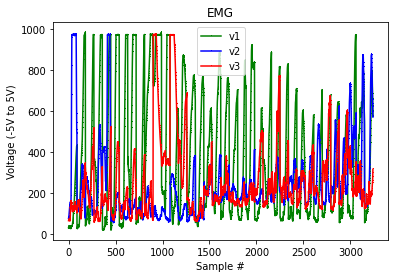

In [2]:
def input_graph(filename):
  # Read dataset into pandas dataframe.
  # Use pandas to read csv and split each column to corresponding column names.
  # Ignores first row, which is the column titles included for the dataset.
  df = pd.read_csv(filename, skiprows=1, names=["v1", "v2", "v3", "label"])

  # Generates index list from 0 to size of column v1.
  index = range(0, len(df['v1']))

  # Extract target values.
  Y = df.loc[:, ['v1']].values
  if debug == True:
    print("Label values: ")
    print(Y)

  plt.plot(index, df['v1'], 'g.', label='v1', linestyle='solid', marker=',')
  plt.plot(index, df['v2'], 'b.', label='v2', linestyle='solid', marker=',')
  plt.plot(index, df['v3'], 'r.', label='v3', linestyle='solid', marker=',')
  plt.title("EMG")
  plt.xlabel("Sample #")
  plt.ylabel("Voltage (-5V to 5V)")
  plt.legend()
  plt.show()

# Put filename into parameter to print input csv file.
input_graph("/content/drive/MyDrive/1) MSU STARX Shared /E&S Team/Sensor/EHS and Sensor Machine Learning EMG System/Implementation/Datasets/Prototype Data/spencer barrer emg profile/3_Sensor_Leg_Up.csv")

## Train Support Vector Machine

### Parse and prepare the data

The next cell parses X (Data) and Y (Label) values from the `.csv` file and transforms them into a format used to train the Support Vector Machine. 

In csv file: 
*   One movement is made up of SAMPLES_PER_FEATURE rows.
*   Cell below will put voltage1, voltage2, voltage3 into a list SAMPLES_PER_FEATURE times. Then that list will be stored in X list.
*   Cell bellow will collect every SAMPLES_PER_FEATURE item in Label column and store it into Y list.

In [3]:
def parse_data(folder, samples_per_feature):
  Y = []
  X = []
  Y = np.array(Y)
  classmap = {}
  for class_idx, filename in enumerate(glob('%s/*.csv' % folder)):
    if debug == True:
      print(filename)
    # Creates dictionary with key as label and value as title of csv files in folder
    class_name = basename(filename)[:-4]
    classmap[class_idx] = class_name
    df = pd.read_csv(filename, skiprows=1, names=["v1", "v2", "v3", "label"])
    num_features = len(classmap)
    # create a one-hot encoded matrix that is used in the output
    one_hot_encoded_features = np.eye(num_features)
    # calculate the number of feature recordings in the file
    num_recordings = int(df.shape[0] / samples_per_feature)
    for i in range(num_recordings):
      tensor = []
      for j in range(samples_per_feature):
        index = i * samples_per_feature + j
        tensor += [
            df["v1"][index],
            df["v2"][index],
            df["v3"][index]
        ]
      Y = np.append(Y, class_idx)
      X.append(tensor)
    # convert the X (Data) and Y (Label) lists into numpy array
  X = np.array(X)
  return X, Y, classmap

X, Y, classmap = parse_data("/content/drive/MyDrive/1) MSU STARX Shared /E&S Team/Sensor/EHS and Sensor Machine Learning EMG System/Implementation/Datasets/Prototype Data/spencer barrer emg profile/", 90)

if debug == True:
    print("X")
    print(X)
    print(X.shape)
    print("Y")
    print(Y)
    print(Y.shape)
    print("classmap: ")
    print(classmap)
    print("Data set parsing and preparation complete.")


/content/drive/MyDrive/1) MSU STARX Shared /E&S Team/Sensor/EHS and Sensor Machine Learning EMG System/Implementation/Datasets/Prototype Data/spencer barrer emg profile/3_Sensor_Heel_Up.csv
/content/drive/MyDrive/1) MSU STARX Shared /E&S Team/Sensor/EHS and Sensor Machine Learning EMG System/Implementation/Datasets/Prototype Data/spencer barrer emg profile/3_Sensor_Leg_Down.csv
/content/drive/MyDrive/1) MSU STARX Shared /E&S Team/Sensor/EHS and Sensor Machine Learning EMG System/Implementation/Datasets/Prototype Data/spencer barrer emg profile/3_Sensor_Leg_Up.csv
X
[[ 65 170 215 ... 449 386 378]
 [ 69 139 145 ... 590 294 296]
 [ 64 147 162 ... 554 449 435]
 ...
 [104 327 372 ... 971 591 353]
 [192 310 190 ... 550 530 143]
 [ 61 147 126 ... 574 571 317]]
(108, 270)
Y
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 2. 

### Build, Train and Test Support Vector Machine Model

Build, train and learn a [Sklearn](https://scikit-learn.org/stable/modules/svm.html) model using the python [micromlgen](https://github.com/eloquentarduino/micromlgen) library.

In [4]:
# Ignore Sklearn model error with Y list parameter not being np array.
warnings.filterwarnings(action="ignore", category=DataConversionWarning)

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook runs.
SEED = 222
np.random.seed(SEED)
random_number = np.random.randint(1000)

# Keep 40% of csv data reserved for testing purpose and 60% data will be used to train and formulate the SVM model.
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.4, random_state=random_number)

# Parameters
C = [0.1,1,10,100,1000,10000]   # Default 1.0
kernel = ['linear','poly','rbf','sigmoid']    # Default rbf
degree = [1,2,3,4,5,6,7,8,9,10,11,12]    # Default 3
# Gamma should not go above or include 1
gamma = [0.00001,0.0001,0.001,0.01,0.1,'scale','auto']   # Default 'scale'
coef0 = [0,1,2,3,4,5,6,7,8,9,10,11,12]   # default = 0.0
shrinking = [True,False]   # Default True
decision_function_shape = ['ovo','ovr']    # default=’ovr’
epsilons = [0.00001,0.0001,0.001,0.01,0.1,1,5,10,100]
k_cross_validation = 3  # Default K value for cross validation (number of folds)

# For arduino due there is 96 KBytes (two banks: 64KB and 32KB) of SRAM and 512 KBytes of flash memory for code.
# Max size of library will be 0.3Mb or 300KBytes
due_memory_allocated = 0.3

# The cutoff of accuracy and cross validation for SVM that adds to csv file.
convergance_cutoff = 0.75

def append_list_as_row(file_name, list_of_elem):
    # Open file in append mode
    with open(file_name, 'a+', newline='') as write_obj:
        # Create a writer object from csv module
        csv_writer = csv.writer(write_obj)
        # Add contents of list as last row in the csv file
        csv_writer.writerow(list_of_elem)

#### Building SVC (Support Vector Classification)

Generates `.csv` file containing all combinations of parameters C, kernel, degree, gamma, coef0, shrinking, cache size, decision function shape, # of Support Vectors and accuracy of SVM with this classifier.

To download `SVC_output.csv`:
1. Open the panel on the left side of Colab by clicking on the __file__ button
1. Right clikc `SVC_output.csv` files and save file to computer.
1. Open file and sort accuracy from largest to smallest.
1. Find the most optimal parameters for SVC and save those parameters.

In [5]:
svm_list_output = []
# Add titles to each column of file.
svm_list_output.append("Kernel")
svm_list_output.append("Cache")
svm_list_output.append("Degree")
svm_list_output.append("Gamma")
svm_list_output.append("Coef0")
svm_list_output.append("Shrinking")
svm_list_output.append("Cache Size")
svm_list_output.append("Decision function shape")
svm_list_output.append("# Support Vectors")
svm_list_output.append("Root Mean Square Error")
svm_list_output.append("Precision")
svm_list_output.append("Recall")
svm_list_output.append("r2")
svm_list_output.append("K Fold Cross Validation")
svm_list_output.append("Mean Accuracy")
append_list_as_row('/content/drive/MyDrive/1) MSU STARX Shared /E&S Team/Sensor/EHS and Sensor Machine Learning EMG System/Implementation/Output/SVM/SVC_output.csv', svm_list_output)
# Clear temporary list
svm_list_output = []

for c in C:
  for d in degree:
    for g in gamma:
      for c0 in coef0:
        for s in shrinking:
          for dfs in decision_function_shape:
            svc = svm.SVC(C=c, kernel='poly', degree=d, gamma=g, coef0=c0, shrinking=s, cache_size=due_memory_allocated, decision_function_shape=dfs).fit(X_train, Y_train)
            # In multi-label classification, this is the subset accuracy which is a harsh metric since you require for each sample that each label set be correctly predicted.
            # Return the mean accuracy on the given test data and labels.
            svc_mean_accuracy = svc.score(X_test, Y_test)
            if debug == True:
              print("SVC: {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}".format('poly', c, d, g, c0, s, due_memory_allocated, dfs, len(svc.support_), '-','-','-','-','-', svc_mean_accuracy))
            if (svc_mean_accuracy >= convergance_cutoff):
              # Model is above convergance_cutoff and now will be stored into lists.         
              svm_list_output.append('poly')   
              svm_list_output.append(c)
              svm_list_output.append(d)
              svm_list_output.append(g)
              svm_list_output.append(c0)
              svm_list_output.append(s)
              svm_list_output.append(due_memory_allocated)
              svm_list_output.append(dfs)
              svm_list_output.append(len(svc.support_))
              svm_list_output.append("-")
              svm_list_output.append("-")
              svm_list_output.append("-")
              svm_list_output.append("-")
              svm_list_output.append("-")
              svm_list_output.append(svc_mean_accuracy)
              # Save to file
              append_list_as_row("/content/drive/MyDrive/1) MSU STARX Shared /E&S Team/Sensor/EHS and Sensor Machine Learning EMG System/Implementation/Output/SVM/SVC_output.csv", svm_list_output)
              # Clear temporary list
              svm_list_output = []
if debug == True:
  clear_output()
  print("SVM Computations complete!")

SVM Computations complete!


In [ ]:
svm_list_output = []
for c in C:
  for d in degree:
    for g in gamma:
      for c0 in coef0:
        for s in shrinking:
          for dfs in decision_function_shape:
            svc = svm.SVC(C=c, kernel='linear', degree=d, gamma=g, coef0=c0, shrinking=s, cache_size=due_memory_allocated, decision_function_shape=dfs).fit(X_train, Y_train)
            # In multi-label classification, this is the subset accuracy which is a harsh metric since you require for each sample that each label set be correctly predicted.
            # Return the mean accuracy on the given test data and labels.
            svc_mean_accuracy = svc.score(X_test, Y_test)
            # Validate robustness of above model using K-Fold Cross validation technique
            # We give cross_val_score a model, the entire data set and its real values and the number of folds.
            scores_res = model_selection.cross_val_score(svc, X, Y, scoring='accuracy', cv=k_cross_validation, n_jobs=-1)
            svc_k_fold_cross_validation_mean = scores_res.mean()
            # Use scores to determine validity of model
            scores = model_selection.cross_validate(svc, X, Y, cv=3,
                        scoring=('precision_macro', 'recall_macro', 'r2', 'neg_root_mean_squared_error'),
                        return_train_score=True)
            root_mean_square_error = -1*scores['test_neg_root_mean_squared_error'].mean()
            precision = scores['test_precision_macro'].mean()
            recall = scores['test_recall_macro'].mean()
            r2 = scores['train_r2'].mean()
            if debug == True:
              print("SVC: {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}".format('linear', c, d, g, c0, s, due_memory_allocated, dfs, len(svc.support_), root_mean_square_error, precision, recall, r2, svc_k_fold_cross_validation_mean, svc_mean_accuracy))
            if (svc_mean_accuracy >= convergance_cutoff and svc_k_fold_cross_validation_mean >= convergance_cutoff and precision >= convergance_cutoff and recall >= convergance_cutoff and r2 >= convergance_cutoff):
              # Model is above convergance_cutoff and now will be stored into lists.         
              svm_list_output.append('linear')   
              svm_list_output.append(c)
              svm_list_output.append(d)
              svm_list_output.append(g)
              svm_list_output.append(c0)
              svm_list_output.append(s)
              svm_list_output.append(due_memory_allocated)
              svm_list_output.append(dfs)
              svm_list_output.append(len(svc.support_))
              svm_list_output.append(root_mean_square_error)
              svm_list_output.append(precision)
              svm_list_output.append(recall)
              svm_list_output.append(r2)
              svm_list_output.append(svc_k_fold_cross_validation_mean)
              svm_list_output.append(svc_mean_accuracy)
              # Save to file
              append_list_as_row("/content/drive/MyDrive/1) MSU STARX Shared /E&S Team/Sensor/EHS and Sensor Machine Learning EMG System/Implementation/Output/SVM/SVC_output.csv", svm_list_output)
              # Clear temporary list
              svm_list_output = []

if debug == True:
  clear_output()
  print("SVM Computations complete!")

SVM Computations complete!


In [ ]:
svm_list_output = []
for c in C:
  for d in degree:
    for g in gamma:
      for c0 in coef0:
        for s in shrinking:
          for dfs in decision_function_shape:
            svc = svm.SVC(C=c, kernel='rbf', degree=d, gamma=g, coef0=c0, shrinking=s, cache_size=due_memory_allocated, decision_function_shape=dfs).fit(X_train, Y_train)
            # In multi-label classification, this is the subset accuracy which is a harsh metric since you require for each sample that each label set be correctly predicted.
            # Return the mean accuracy on the given test data and labels.
            svc_mean_accuracy = svc.score(X_test, Y_test)
            # Validate robustness of above model using K-Fold Cross validation technique
            # We give cross_val_score a model, the entire data set and its real values and the number of folds.
            scores_res = model_selection.cross_val_score(svc, X, Y, cv=k_cross_validation)
            svc_k_fold_cross_validation_mean = scores_res.mean()
            # Use scores to determine validity of model
            scores = model_selection.cross_validate(svc, X, Y, cv=3,
                        scoring=('precision_macro', 'recall_macro', 'r2', 'neg_root_mean_squared_error'),
                        return_train_score=True)
            root_mean_square_error = -1*scores['test_neg_root_mean_squared_error'].mean()
            precision = scores['test_precision_macro'].mean()
            recall = scores['test_recall_macro'].mean()
            r2 = scores['train_r2'].mean()
            if debug == True:
              print("SVC: {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}".format('rbf', c, d, g, c0, s, due_memory_allocated, dfs, len(svc.support_), root_mean_square_error, precision, recall, r2, svc_k_fold_cross_validation_mean, svc_mean_accuracy))
            if (svc_mean_accuracy >= convergance_cutoff and svc_k_fold_cross_validation_mean >= convergance_cutoff and precision >= convergance_cutoff and recall >= convergance_cutoff and r2 >= convergance_cutoff):
              # Model is above convergance_cutoff and now will be stored into lists.         
              svm_list_output.append('rbf')
              svm_list_output.append(c)
              svm_list_output.append(d)
              svm_list_output.append(g)
              svm_list_output.append(c0)
              svm_list_output.append(s)
              svm_list_output.append(due_memory_allocated)
              svm_list_output.append(dfs)
              svm_list_output.append(len(svc.support_))
              svm_list_output.append(root_mean_square_error)
              svm_list_output.append(precision)
              svm_list_output.append(recall)
              svm_list_output.append(r2)
              svm_list_output.append(svc_k_fold_cross_validation_mean)
              svm_list_output.append(svc_mean_accuracy)
              # Save to file
              append_list_as_row("/content/drive/MyDrive/1) MSU STARX Shared /E&S Team/Sensor/EHS and Sensor Machine Learning EMG System/Implementation/Output/SVM/SVC_output.csv", svm_list_output)
              # Clear temporary list
              svm_list_output = []
if debug == True:
  clear_output()
  print("SVM Computations complete!")

SVM Computations complete!


In [ ]:
svm_list_output = []
for c in C:
  for d in degree:
    for g in gamma:
      for c0 in coef0:
        for s in shrinking:
          for dfs in decision_function_shape:
            svc = svm.SVC(C=c, kernel='sigmoid', degree=d, gamma=g, coef0=c0, shrinking=s, cache_size=due_memory_allocated, decision_function_shape=dfs).fit(X_train, Y_train)
            # In multi-label classification, this is the subset accuracy which is a harsh metric since you require for each sample that each label set be correctly predicted.
            # Return the mean accuracy on the given test data and labels.
            svc_mean_accuracy = svc.score(X_test, Y_test)
            # Validate robustness of above model using K-Fold Cross validation technique
            # We give cross_val_score a model, the entire data set and its real values and the number of folds.
            scores_res = model_selection.cross_val_score(svc, X, Y, cv=k_cross_validation)
            svc_k_fold_cross_validation_mean = scores_res.mean()
            # Use scores to determine validity of model
            scores = model_selection.cross_validate(svc, X, Y, cv=3,
                        scoring=('precision_macro', 'recall_macro', 'r2', 'neg_root_mean_squared_error'),
                        return_train_score=True)
            root_mean_square_error = -1*scores['test_neg_root_mean_squared_error'].mean()
            precision = scores['test_precision_macro'].mean()
            recall = scores['test_recall_macro'].mean()
            r2 = scores['train_r2'].mean()
            if debug == True:
              print("SVC: {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}".format('sigmoid', c, d, g, c0, s, due_memory_allocated, dfs, len(svc.support_), root_mean_square_error, precision, recall, r2, svc_k_fold_cross_validation_mean, svc_mean_accuracy))
            if (svc_mean_accuracy >= convergance_cutoff and svc_k_fold_cross_validation_mean >= convergance_cutoff and precision >= convergance_cutoff and recall >= convergance_cutoff and r2 >= convergance_cutoff):
              # Model is above convergance_cutoff and now will be stored into lists.         
              svm_list_output.append('sigmoid')   
              svm_list_output.append(c)
              svm_list_output.append(d)
              svm_list_output.append(g)
              svm_list_output.append(c0)
              svm_list_output.append(s)
              svm_list_output.append(due_memory_allocated)
              svm_list_output.append(dfs)
              svm_list_output.append(len(svc.support_))
              svm_list_output.append(root_mean_square_error)
              svm_list_output.append(precision)
              svm_list_output.append(recall)
              svm_list_output.append(r2)
              svm_list_output.append(svc_k_fold_cross_validation_mean)
              svm_list_output.append(svc_mean_accuracy)
              # Save to file
              append_list_as_row("/content/drive/MyDrive/1) MSU STARX Shared /E&S Team/Sensor/EHS and Sensor Machine Learning EMG System/Implementation/Output/SVM/SVC_output.csv", svm_list_output)
              # Clear temporary list
              svm_list_output = []
if debug == True:
  clear_output()
  print("SVM Computations complete!")

#### Building OneClassSVM (One Class Support Vector Classification)

Generates `.csv` file containing all combinations of parameters kernel, degree, gamma, coef0, shrinking, cache size, # of Support Vectors and accuracy of SVM with this classifier.

To download `OneClassSVM_output.csv`:
1. Open the panel on the left side of Colab by clicking on the __file__ button
1. Right click `OneClassSVM_output.csv` files and save file to computer.
1. Open file and sort accuracy from largest to smallest.
1. Find the most optimal parameters for OneClassSVM and save those parameters.

In [ ]:
"""
svm_file_output = []
svm_list_output = []

# Add titles to each column of file.
svm_list_output.append("Kernel")
svm_list_output.append("Degree")
svm_list_output.append("Gamma")
svm_list_output.append("Coef0")
svm_list_output.append("Shrinking")
svm_list_output.append("Cache Size")
svm_list_output.append("# of Support Vectors")
svm_list_output.append("Average")
svm_file_output.append(svm_list_output)
# Clear titles
svm_list_output = []

for k in kernel:
  for d in degree:
    for g in gamma:
      for c0 in coef0:
        for s in shrinking:
          ocsvm = svm.OneClassSVM(kernel=k, degree=d, gamma=g, coef0=c0, shrinking=s, cache_size=due_memory_allocated).fit(X_train, Y_train)
          # Measure accuracy of model compared with test data.
          ocsvm_accuracy = ocsvm.score(X_test, Y_test)
          if debug == True:
            print("OneClassSVM: {}, {}, {}, {}, {}, {}, {}, {}".format(k, d, g, c0, s, due_memory_allocated, len(ocsvm.support_), ocsvm_accuracy))
          if (ocsvm_accuracy >= convergance_cutoff):
              # Model is above convergance_cutoff and now will be stored into lists.
              svm_list_output.append(k)
              svm_list_output.append(d)
              svm_list_output.append(g)
              svm_list_output.append(c0)
              svm_list_output.append(s)
              svm_list_output.append(due_memory_allocated)
              svm_list_output.append(len(ocsvm.support_))
              svm_list_output.append(ocsvm_accuracy)
              # Append list to final output for file
              svm_file_output.append(svm_list_output)
              # Clear temporary list
              svm_list_output = []
if debug == True:
    print("SVM Computations complete! Saving to File.")

# Save to file
with open('OneClassSVM_output.csv', 'w') as f:
    # using csv.writer method from CSV package 
    write = csv.writer(f)
    write.writerows(svm_file_output)

if debug == True:
    print("Saving to File Complete!")
"""

'\nsvm_file_output = []\nsvm_list_output = []\n\n# Add titles to each column of file.\nsvm_list_output.append("Kernel")\nsvm_list_output.append("Degree")\nsvm_list_output.append("Gamma")\nsvm_list_output.append("Coef0")\nsvm_list_output.append("Shrinking")\nsvm_list_output.append("Cache Size")\nsvm_list_output.append("# of Support Vectors")\nsvm_list_output.append("Average")\nsvm_file_output.append(svm_list_output)\n# Clear titles\nsvm_list_output = []\n\nfor k in kernel:\n  for d in degree:\n    for g in gamma:\n      for c0 in coef0:\n        for s in shrinking:\n          ocsvm = svm.OneClassSVM(kernel=k, degree=d, gamma=g, coef0=c0, shrinking=s, cache_size=due_memory_allocated).fit(X_train, Y_train)\n          # Measure accuracy of model compared with test data.\n          ocsvm_accuracy = ocsvm.score(X_test, Y_test)\n          if debug == True:\n            print("OneClassSVM: {}, {}, {}, {}, {}, {}, {}, {}".format(k, d, g, c0, s, due_memory_allocated, len(ocsvm.support_), ocsvm_a

#### Building RVM (Relevance Vector Machine Classification)

Generates `.csv` file containing all combinations of parameters kernel, degree, gamma, coef0, C, epsilon, shrinking, cache size, # of Support Vectors and accuracy of SVM with this classifier.

To download `RVM_output.csv`:
1. Open the panel on the left side of Colab by clicking on the __file__ button
1. Right click `RVM_output.csv` files and save file to computer.
1. Open file and sort accuracy from largest to smallest.
1. Find the most optimal parameters for RVM and save those parameters.

In [ ]:
"""
svm_list_output = []

# Add titles to each column of file.
svm_list_output.append("Kernel")
svm_list_output.append("Degree")
svm_list_output.append("Gamma")
svm_list_output.append("Coef0")
svm_list_output.append("C")
svm_list_output.append("Epsilon")
svm_list_output.append("Shrinking")
svm_list_output.append("Cache Size")
svm_list_output.append("# of Support Vectors")
svm_list_output.append("Average")
append_list_as_row('/content/drive/MyDrive/1) MSU STARX Shared /E&S Team/Sensor/EHS and Sensor Machine Learning EMG System/Implementation/Output/SVC/RVM_output.csv',svm_list_output )
# Clear temporary list
svm_list_output = []

for d in degree:
  for g in gamma:
    for c0 in coef0:
      for c in C:
        for e in epsilons:
          for s in shrinking:
            rvm = svm.SVR(kernel=k, degree=d, gamma=g, coef0=c0, C=c, epsilon=e, shrinking=s, cache_size=due_memory_allocated).fit(X_train, Y_train)
            # In multi-label classification, this is the subset accuracy which is a harsh metric since you require for each sample that each label set be correctly predicted.
            # Return the mean accuracy on the given test data and labels.
            rvm_accuracy = rvm.score(X_test, Y_test)
            if debug == True:
              print("RVM: {}, {}, {}, {}, {}, {}, {}, {}, {}, {}".format(k, d, g, c0, c, e, s, due_memory_allocated, len(rvm.support_), rvm_accuracy))
            if (rvm_accuracy >= convergance_cutoff):
              # Model is above convergance_cutoff and now will be stored into lists.
              svm_list_output.append(k)
              svm_list_output.append(d)
              svm_list_output.append(g)
              svm_list_output.append(c0)
              svm_list_output.append(c)
              svm_list_output.append(e)
              svm_list_output.append(s)
              svm_list_output.append(due_memory_allocated)
              svm_list_output.append(len(rvm.support_))
              svm_list_output.append(rvm_accuracy)
              append_list_as_row('/content/drive/MyDrive/1) MSU STARX Shared /E&S Team/Sensor/EHS and Sensor Machine Learning EMG System/Implementation/Output/SVC/RVM_output.csv',svm_list_output )
              # Clear temporary list
              svm_list_output = []

for d in degree:
  for g in gamma:
    for c0 in coef0:
      for c in C:
        for e in epsilons:
          for s in shrinking:
            rvm = svm.SVR(kernel=k, degree=d, gamma=g, coef0=c0, C=c, epsilon=e, shrinking=s, cache_size=due_memory_allocated).fit(X_train, Y_train)
            # In multi-label classification, this is the subset accuracy which is a harsh metric since you require for each sample that each label set be correctly predicted.
            # Return the mean accuracy on the given test data and labels.
            rvm_accuracy = rvm.score(X_test, Y_test)
            if debug == True:
              print("RVM: {}, {}, {}, {}, {}, {}, {}, {}, {}, {}".format(k, d, g, c0, c, e, s, due_memory_allocated, len(rvm.support_), rvm_accuracy))
            if (rvm_accuracy >= convergance_cutoff):
              # Model is above convergance_cutoff and now will be stored into lists.
              svm_list_output.append(k)
              svm_list_output.append(d)
              svm_list_output.append(g)
              svm_list_output.append(c0)
              svm_list_output.append(c)
              svm_list_output.append(e)
              svm_list_output.append(s)
              svm_list_output.append(due_memory_allocated)
              svm_list_output.append(len(rvm.support_))
              svm_list_output.append(rvm_accuracy)
              append_list_as_row('/content/drive/MyDrive/1) MSU STARX Shared /E&S Team/Sensor/EHS and Sensor Machine Learning EMG System/Implementation/Output/SVC/RVM_output.csv',svm_list_output )
              # Clear temporary list
              svm_list_output = []

for d in degree:
  for g in gamma:
    for c0 in coef0:
      for c in C:
        for e in epsilons:
          for s in shrinking:
            rvm = svm.SVR(kernel=k, degree=d, gamma=g, coef0=c0, C=c, epsilon=e, shrinking=s, cache_size=due_memory_allocated).fit(X_train, Y_train)
            # In multi-label classification, this is the subset accuracy which is a harsh metric since you require for each sample that each label set be correctly predicted.
            # Return the mean accuracy on the given test data and labels.
            rvm_accuracy = rvm.score(X_test, Y_test)
            if debug == True:
              print("RVM: {}, {}, {}, {}, {}, {}, {}, {}, {}, {}".format(k, d, g, c0, c, e, s, due_memory_allocated, len(rvm.support_), rvm_accuracy))
            if (rvm_accuracy >= convergance_cutoff):
              # Model is above convergance_cutoff and now will be stored into lists.
              svm_list_output.append(k)
              svm_list_output.append(d)
              svm_list_output.append(g)
              svm_list_output.append(c0)
              svm_list_output.append(c)
              svm_list_output.append(e)
              svm_list_output.append(s)
              svm_list_output.append(due_memory_allocated)
              svm_list_output.append(len(rvm.support_))
              svm_list_output.append(rvm_accuracy)
              append_list_as_row('/content/drive/MyDrive/1) MSU STARX Shared /E&S Team/Sensor/EHS and Sensor Machine Learning EMG System/Implementation/Output/SVC/RVM_output.csv',svm_list_output )
              # Clear temporary list
              svm_list_output = []

for d in degree:
  for g in gamma:
    for c0 in coef0:
      for c in C:
        for e in epsilons:
          for s in shrinking:
            rvm = svm.SVR(kernel=k, degree=d, gamma=g, coef0=c0, C=c, epsilon=e, shrinking=s, cache_size=due_memory_allocated).fit(X_train, Y_train)
            # In multi-label classification, this is the subset accuracy which is a harsh metric since you require for each sample that each label set be correctly predicted.
            # Return the mean accuracy on the given test data and labels.
            rvm_accuracy = rvm.score(X_test, Y_test)
            if debug == True:
              print("RVM: {}, {}, {}, {}, {}, {}, {}, {}, {}, {}".format(k, d, g, c0, c, e, s, due_memory_allocated, len(rvm.support_), rvm_accuracy))
            if (rvm_accuracy >= convergance_cutoff):
              # Model is above convergance_cutoff and now will be stored into lists.
              svm_list_output.append(k)
              svm_list_output.append(d)
              svm_list_output.append(g)
              svm_list_output.append(c0)
              svm_list_output.append(c)
              svm_list_output.append(e)
              svm_list_output.append(s)
              svm_list_output.append(due_memory_allocated)
              svm_list_output.append(len(rvm.support_))
              svm_list_output.append(rvm_accuracy)
              append_list_as_row('/content/drive/MyDrive/1) MSU STARX Shared /E&S Team/Sensor/EHS and Sensor Machine Learning EMG System/Implementation/Output/SVC/RVM_output.csv',svm_list_output )
              # Clear temporary list
              svm_list_output = []
if debug == True:
    print("SVM Computations complete! Saving to File.")
if debug == True:
    print("Saving to File Complete!")
"""

'\nsvm_list_output = []\n\n# Add titles to each column of file.\nsvm_list_output.append("Kernel")\nsvm_list_output.append("Degree")\nsvm_list_output.append("Gamma")\nsvm_list_output.append("Coef0")\nsvm_list_output.append("C")\nsvm_list_output.append("Epsilon")\nsvm_list_output.append("Shrinking")\nsvm_list_output.append("Cache Size")\nsvm_list_output.append("# of Support Vectors")\nsvm_list_output.append("Average")\nappend_list_as_row(\'/content/drive/MyDrive/1) MSU STARX Shared /E&S Team/Sensor/EHS and Sensor Machine Learning EMG System/Implementation/Output/SVC/RVM_output.csv\',svm_list_output )\n# Clear temporary list\nsvm_list_output = []\n\nfor d in degree:\n  for g in gamma:\n    for c0 in coef0:\n      for c in C:\n        for e in epsilons:\n          for s in shrinking:\n            rvm = svm.SVR(kernel=k, degree=d, gamma=g, coef0=c0, C=c, epsilon=e, shrinking=s, cache_size=due_memory_allocated).fit(X_train, Y_train)\n            # In multi-label classification, this is the s

## Verify 

Graph selected model on its performance vs validation. You can verify accuracy and K Fold Cross Validation of the most optimal models that was collected from files.


In [ ]:
# Model to examine.
poly_svc1 = svm.SVC(C=0.1, kernel='linear', degree=6, gamma=0.1, coef0=1, shrinking=False, cache_size=due_memory_allocated, decision_function_shape='ovr').fit(X_train, Y_train)


# Root mean square error: The  root-mean-square error (RMSE) is a frequently used measure of the differences between values (sample or population values) predicted by a model or an estimator and the values observed. 
# It measures the standard deviation4 of the errors the system makes in its predictions. Lower vaules indicate a better fit. 

# Precision: The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative. The best value is 1 and the worst value is 0.

# Recall: The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples. The best value is 1 and the worst value is 0.

# R^2 (coefficient of determination) regression score function. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

scores = model_selection.cross_validate(poly_svc1, X, Y, cv=3,
                        scoring=('precision_macro', 'recall_macro', 'r2', 'neg_root_mean_squared_error'),
                        return_train_score=True)
root_mean_square_error = -1*scores['test_neg_root_mean_squared_error'].mean()
precision = scores['test_precision_macro'].mean()
recall = scores['test_recall_macro'].mean()
r2 = scores['train_r2'].mean()

# In multi-label classification, this is the subset accuracy which is a harsh metric since you require for each sample that each label set be correctly predicted.
# Return the mean accuracy on the given test data and labels.
#score = poly_svc1.score(X_test, Y_test)
#print(score)

### Graph the Decision Boundaries

Comparison of different Support Vectors on a 2D projection. We only consider the first 2 features of this dataset:

*   Voltage 1
*   Voltage 2



Poly Graphs: 


/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


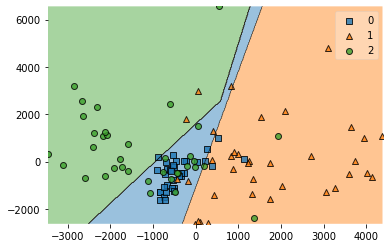

In [ ]:
def plot_boundaries(classifier, X, Y):
    """
    classifier: an untrained classifier
    X: features matrix
    Y: labels vector
    classmap: a dict where the key is the class index, the value is the class name. 
              For example {0: "setosa", 1: "versicolor", 2: "virginica"}
    """
    labels = None
    # project X into 2d
    X = PCA(n_components=2).fit_transform(X)
    plot_decision_regions(X, Y.astype(np.uint8),
                          clf=classifier.fit(X, Y),
                          legend=1,)
    plt.show()

print("Poly Graphs: ")
plot_boundaries(poly_svc1, X, Y)


### Predict classifier for user defined input
Predict the Target with a given input parameter

In [ ]:
# Enter a input that you would find in X (Data) at the size of SAMPLES_PER_FEATURES *  FEATURES (3 being v1, v2, v3)
data_for_prediction = []

# Model you want to test.
clf_ob = svm.SVC(kernel='linear', C=1, gamma=0.001).fit(X_train, Y_train)

# Calculate predicted classifier for given data_for_prediction defined by user.
# predict can handle multiple parameters from data_for_prediction
p_res = clf_ob.predict(data_for_prediction[0])
p_prob_res = clf_ob.predict_proba(data_for_prediction[0])
p_log_prob_res = clf_ob.predict_log_proba(data_for_prediction[0])
print("Predicted Target: ", p_res[0])
print("Predicted Probability Target: ", p_prob_res[0])
print("Predicted Log Probability Target: ", p_log_prob_res[0])

IndexError: ignored

## Export Python to C Library

Now you can convert the SVM trained classifier to plain C code using the micromlgen package. Copy output of cell below into a library file. Place the library file you created into arduino script enviroment.

In [ ]:
# Select highest average score and fill line below.
clf_ob = svm.SVC(kernel='linear', C=1, gamma=0.001).fit(X_train, Y_train)

# Convert trained classifier to C code.
c_code = port(clf_ob, classmap=classmap)
print(c_code)